In [1]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import wrf
import netCDF4 as nc
import warnings
import pyart
import pandas as pd
import tqdm
import metpy.calc as mpcalc

warnings.simplefilter("ignore")


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead


0.3.0


In [2]:
def load_transect(tpath,t_fname,hpath,h_fname):

    #Load cross section
    ctrl = xr.open_dataset(tpath + t_fname)
    
    #Change theta pert. Define as the perturbation in theta relative to the transect at each height.
    ctrl["theta_pert"] = ctrl["theta"] - ctrl.theta.sel(cross_line_idx=slice(25,50)).mean(("cross_line_idx","transect"))
    
    #Define cold pool depth, H, as when the mean cold pool theta perturbation goes above -1 K
    thresh=-1
    cond = (ctrl.sel(cross_line_idx=slice(0,25),vertical=slice(0,3000)).theta_pert).mean("cross_line_idx") <= thresh
    heights = np.repeat(ctrl.sel(vertical=slice(0,3000)).vertical.values[np.newaxis],cond.transect.shape[0],axis=0)
    H = np.nanmax(np.where(cond,heights,np.nan),axis=1)
    ctrl["H"] = (["transect"],H)
    
    #Cold pool speed, Uc, defined as the average along-transect wind speeds in the cold pool
    # Uc = [ctrl["along_transect_wind"].sel(cross_line_idx=slice(0,25),vertical=slice(0,h),transect=t).mean(("cross_line_idx","vertical"))\
    #       for h, t in zip(H, range(ctrl.transect.shape[0]))]
    # ctrl["Uc"] = (["transect"],Uc)
    ctrl["Uc"] = ctrl["along_transect_wind"].sel(cross_line_idx=slice(0,25)).isel(vertical=0).max(("cross_line_idx"))    
    
    #Get system relative line-perpendicular winds
    ctrl["system_relative_along_transect_wind"] = ctrl["along_transect_wind"] - ctrl["Uc"]    
    
    return ctrl.assign_coords({"transect":ctrl.transect})
    
def latlon_dist(lat, lon, lats, lons):

        #Calculate great circle distance (Harversine) between a lat lon point (lat, lon) and a list of lat lon
        # points (lats, lons)

        R = 6373.0

        lat1 = np.deg2rad(lat)
        lon1 = np.deg2rad(lon)
        lat2 = np.deg2rad(lats)
        lon2 = np.deg2rad(lons)

        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

        return (R * c)    
    
    

In [3]:
tpath = "/g/data/w40/ab4502/WRF_simulations/transects/"
hpath = "/g/data/w40/ab4502/WRF_simulations/tasman_d04_20231015_20231016_ramssa_shortlead/"

t_fname = ["tasman_d04_20231015_20231016_ramssa_shortlead_02:30:00.nc",
           "tasman_d04_20231015_20231016_ramssa_shortlead_03:00:00.nc",
           "tasman_d04_20231015_20231016_ramssa_shortlead_03:30:00.nc"]
h_fname = ["highres_d04_2023-10-16_02:30:00",
           "highres_d04_2023-10-16_03:00:00",
           "highres_d04_2023-10-16_03:30:00"]
ctrl_list = []

for t, h in tqdm.tqdm(zip(t_fname,h_fname)):
    ctrl = load_transect(tpath,t,hpath,h)
    ctrl_list.append(ctrl)
    
for i in range(1,len(ctrl_list)):
    ctrl_list[i] = ctrl_list[i].interp({"cross_line_idx":ctrl_list[0].cross_line_idx},method="linear")
    
ctrl_list = xr.concat(ctrl_list,"Time")    

3it [00:04,  1.67s/it]


In [4]:
def plot_theta_transect(ax,ctrl,remove_xticks=True,remove_yticks=True,hstep=10,vstep=2,vtop=6000,hstart=2,hend=50,add_qk=False,
                       ws_levs=np.linspace(5,20,11)):
    
    c=xr.plot.contour(
        ctrl.sel(vertical=slice(0,vtop),cross_line_idx=slice(hstart,hend)).theta_pert.mean("transect"),
        levels=[-3,-2.5,-2,-1.5,-1],colors=["grey"],alpha=1,add_colorbar=False,linewidths=2,linestyles="--")
    text = plt.clabel(c,fontsize=14); [t.set_fontweight("bold") for t in text]; [t.set_color("k") for t in text]
    c=xr.plot.contour(
        ctrl.sel(vertical=slice(0,vtop),cross_line_idx=slice(hstart,hend)).w.mean("transect"),
        levels=[1,2,3],colors=["k"],alpha=1,add_colorbar=False,linewidths=1,linestyles="-")   
    cf=xr.plot.contourf(
        ctrl.sel(vertical=slice(0,vtop),cross_line_idx=slice(hstart,hend)).ground_rel_ws.mean("transect"),
        levels=ws_levs,cmap="Reds",alpha=1,add_colorbar=False,extend="both")    

    q=ctrl.sel(vertical=slice(0,vtop,vstep),cross_line_idx=slice(hstart,hend,hstep)).mean("transect").plot.quiver(
        "cross_line_idx","vertical","system_relative_along_transect_wind","w",width=0.005,color="k",scale=150,add_guide=False)
    if add_qk:
        qk=plt.quiverkey(q,0.51,0.88,10,"Density current-relative winds, 10 m/s: ",coordinates="figure",labelpos="N")
    
    plt.ylim([0,vtop])
    plt.xlabel("")
    plt.ylabel("")
    plt.title("")
    if remove_xticks:
        ax.set_xticklabels("")
    if remove_yticks:
        ax.set_yticklabels("")        
    return cf

def plot_wind_transect(ax,ctrl):
    xr.plot.contourf(ctrl.sel(vertical=slice(0,6000)).ground_rel_ws.mean("transect"),levels=np.linspace(10,30,11),cmap="Reds",extend="both")
    xr.plot.contour(ctrl.sel(vertical=slice(0,6000)).ground_rel_ws.mean("transect"),levels=np.linspace(10,30,11),colors=["k"],linewidths=0.5)
    ctrl.sel(vertical=slice(0,6000,2),cross_line_idx=slice(2,50,10)).mean("transect").plot.quiver("cross_line_idx","vertical","system_relative_along_transect_wind","w",
                                                                                                  width=0.005,color="k",scale=100)
    plt.ylabel("")
    plt.ylim([0,6000])

def plot_p_transect(ax,ctrl,remove_xticks=True,remove_yticks=True):
    c=xr.plot.contourf(ctrl.sel(vertical=slice(0,6000)).p_pert.mean("transect"),levels=np.linspace(-0.5,0.5,11),cmap="RdBu_r",add_colorbar=False)
    xr.plot.contour(ctrl.sel(vertical=slice(0,6000)).buoyancy.mean("transect"),levels=[-0.9,-0.06,-0.03,0,0.01,0.02,0.04],colors="k",linewidths=[2])
    ctrl.sel(vertical=slice(0,6000,2),cross_line_idx=slice(2,50,10)).mean("transect").plot.quiver("cross_line_idx","vertical","system_relative_along_transect_wind","w",
                                                                                                  width=0.006,color="k",scale=75)
    plt.ylabel("")
    plt.ylim([0,6000])
    
    plt.xlabel("")
    plt.ylabel("")
    plt.title("")
    if remove_xticks:
        ax.set_xticklabels("")
    if remove_yticks:
        ax.set_yticklabels("")        
    return c    
        

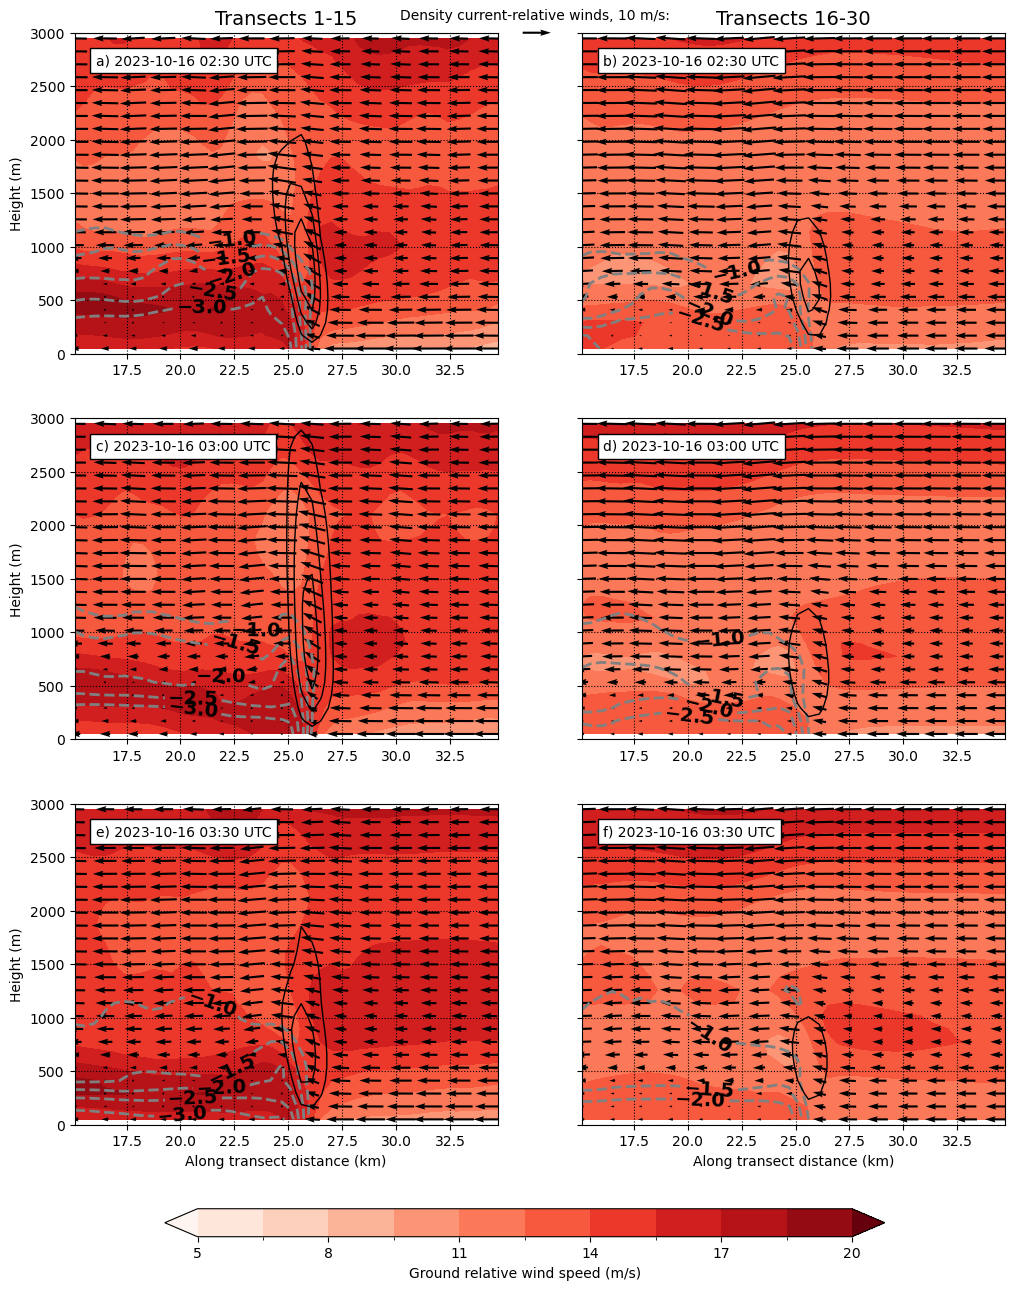

In [ ]:
rows=3
cols=2
cnt=0
plt.figure(figsize=[12,14])
letters=["a","b","c","d","e","f"]
for t in [0,1,2]:
    ax=plt.subplot(rows,cols, (cnt*cols)+1)
    c=plot_theta_transect(ax,ctrl_list.isel(Time=t).sel(transect=slice(0,14)),remove_xticks=False,remove_yticks=False,vtop=3000,hstep=3,hstart=15,hend=35,vstep=1)
    if t == 0:
        plt.title("Transects 1-15",fontsize=14)
    if t == 2:
        plt.xlabel("Along transect distance (km)")
    plt.ylabel("Height (m)")
    ax.grid(color="k",ls=":")
    ax.text(0.05,0.9,letters[(cnt*cols)]+") "+pd.to_datetime(ctrl_list.isel(Time=t).Time.values).strftime("%Y-%m-%d %H:%M UTC"),transform=ax.transAxes,bbox={"ec":"k","fc":"white"})    

    ax=plt.subplot(rows,cols, (cnt*cols)+2)
    if t == 2:
        add_qk=True
    else:
        add_qk=False
    c=plot_theta_transect(ax,ctrl_list.isel(Time=t).sel(transect=slice(15,30)),remove_xticks=False,remove_yticks=True,vtop=3000,hstep=3,hstart=15,hend=35,vstep=1,add_qk=add_qk)
    if t ==0:
        plt.title("Transects 16-30",fontsize=14)
    if t==2:
        plt.xlabel("Along transect distance (km)")        
        cb=plt.colorbar(c,plt.axes([0.2,0.02,0.6,0.02]),orientation="horizontal")
        cb.set_label("Ground relative wind speed (m/s)")
    ax.grid(color="k",ls=":")
    ax.text(0.05,0.9,letters[(cnt*cols)+1]+") "+pd.to_datetime(ctrl_list.isel(Time=t).Time.values).strftime("%Y-%m-%d %H:%M UTC"),transform=ax.transAxes,bbox={"ec":"k","fc":"white"})    
    
    cnt=cnt+1
    
plt.subplots_adjust(bottom=0.1)    
plt.savefig("/g/data/w40/ab4502/IN2023_V06/figs/ctrl_transects.jpeg",dpi=400,bbox_inches="tight")

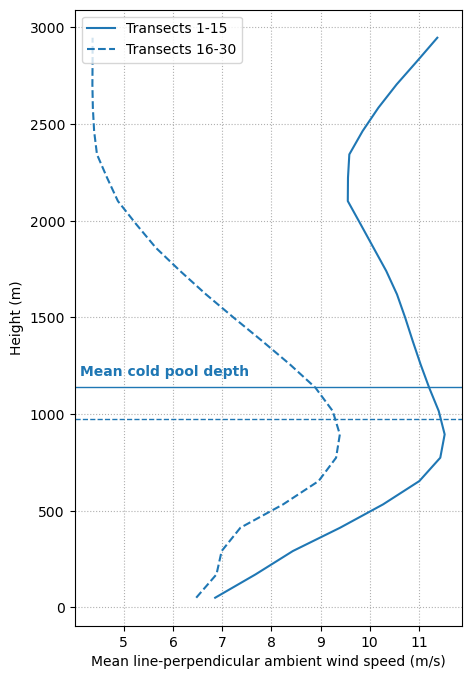

In [12]:
plt.figure(figsize=[5,8])
ctrl_list.along_transect_wind.sel(cross_line_idx=slice(25,50),vertical=slice(0,3000),transect=slice(0,14)).mean(("Time","transect","cross_line_idx")).plot(\
        y="vertical",color="tab:blue",label="Transects 1-15")
plt.gca().axhline(ctrl_list.H.sel(transect=slice(0,14)).mean(),color="tab:blue",lw=1)

ctrl_list.along_transect_wind.sel(cross_line_idx=slice(25,50),vertical=slice(0,3000),transect=slice(15,30)).mean(("Time","transect","cross_line_idx")).plot(\
        y="vertical",color="tab:blue",ls="--",label="Transects 16-30")
plt.gca().axhline(ctrl_list.H.sel(transect=slice(15,30)).mean(),color="tab:blue",ls="--",lw=1)

plt.gca().grid(ls=":")
plt.xlabel("Mean line-perpendicular ambient wind speed (m/s)")
plt.ylabel("Height (m)")
plt.legend(loc="upper left")
plt.text(4.1,1200,"Mean cold pool depth",color="tab:blue",fontweight="bold")
plt.savefig("/g/data/w40/ab4502/IN2023_V06/figs/ctrl_profile.jpeg",dpi=400,bbox_inches="tight")

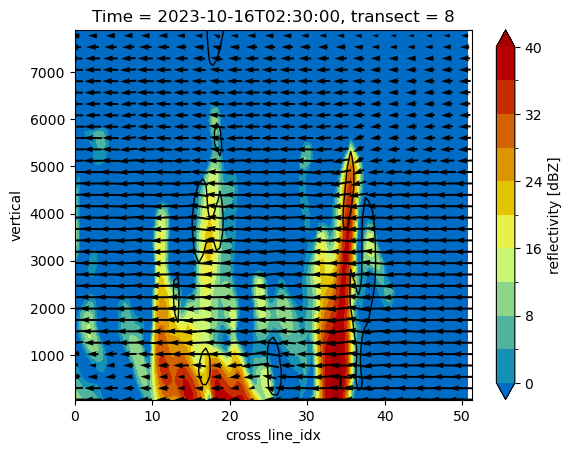

In [40]:
transect=8
t=0
xr.plot.contourf(ctrl_list.isel(Time=t).sel(transect=transect,vertical=slice(0,8000)).reflectivity,cmap=pyart.graph.cm_colorblind.HomeyerRainbow,levels=11,vmin=0,vmax=40)
xr.plot.contour(ctrl_list.isel(Time=t).sel(transect=transect,vertical=slice(0,8000)).w,levels=[1,5,10],colors=["k"],linewidths=[1])
q=ctrl_list.isel(Time=t,cross_line_idx=slice(0,-1,5)).sel(transect=transect,vertical=slice(0,8000,2)).plot.quiver(
    "cross_line_idx","vertical","system_relative_along_transect_wind","w",width=0.005,color="k",scale=200,add_guide=False)

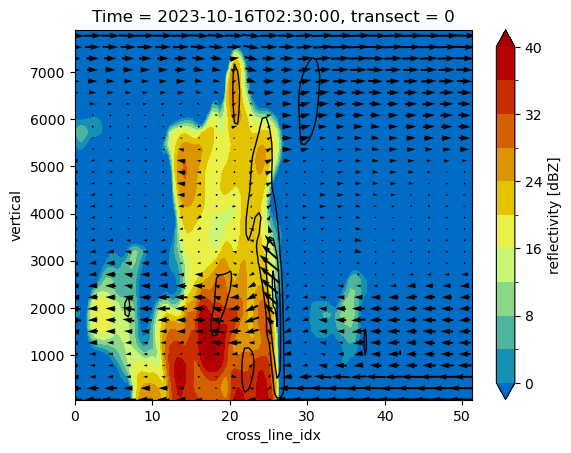

In [38]:
transect=0
t=0
xr.plot.contourf(ctrl_list.isel(Time=t).sel(transect=transect,vertical=slice(0,8000)).reflectivity,cmap=pyart.graph.cm_colorblind.HomeyerRainbow,levels=11,vmin=0,vmax=40)
xr.plot.contour(ctrl_list.isel(Time=t).sel(transect=transect,vertical=slice(0,8000)).w,levels=[1,5,10],colors=["k"],linewidths=[1])
q=ctrl_list.isel(Time=t,cross_line_idx=slice(0,-1,5)).sel(transect=transect,vertical=slice(0,8000,2)).plot.quiver(
    "cross_line_idx","vertical","system_relative_along_transect_wind","w",width=0.005,color="k",scale=200,add_guide=False)

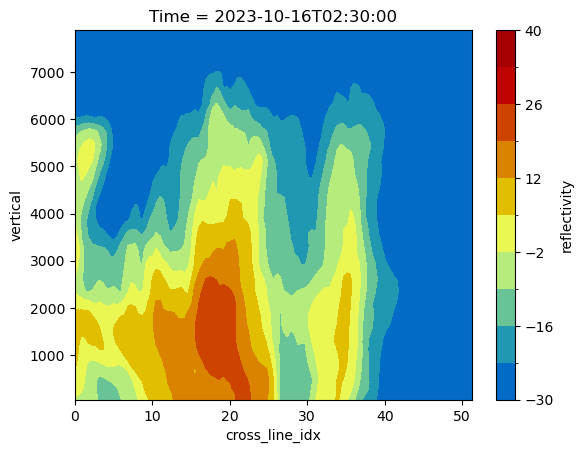

In [60]:
xr.plot.contourf(ctrl_list.isel(Time=0).sel(vertical=slice(0,8000),transect=slice(0,14)).mean("transect").reflectivity,
                 cmap=pyart.graph.cm_colorblind.HomeyerRainbow,levels=11,vmin=-30,vmax=40)